# Optimizing Workforce Allocation using Machine Learning & Linear Programming

![picture](https://i.pinimg.com/736x/b2/6e/96/b26e969d6be61b4f6cefb30d35df70a6.jpg)

# Introduction:

In this use case, we explore the powerful combination of machine learning and linear programming to optimize workforce allocation. Our goal is to assign employees to tasks in a way that maximizes efficiency and ensures that tasks are completed by the most suitable employees. This involves calculating similarity between employee skills and task requirements, and then solving an optimization problem to allocate tasks while respecting constraints like employee availability and task priorities.

In [ ]:
import pandas as pd
import numpy as np
import pulp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# **Step 1:** Loading the Employee and Task Data

![picture](https://i.pinimg.com/474x/7c/f1/ce/7cf1ce2784bb6c9ffeff0ca999e690b4.jpg)




The first step involves loading the employee and task data from CSV files into pandas DataFrames. This data forms the foundation for our analysis and subsequent optimization. The employee_df contains information about each employee's skills, availability, and current workload, while the task_df contains details about the tasks, including required skills, task duration, and priority.

In [ ]:
employee_df= pd.read_csv('employee_data')
task_df = pd.read_csv('task_data')

# **Step 2:** Calculating Skill Similarity Using Machine Learning

![picture](https://i.pinimg.com/736x/db/24/c7/db24c78cc537ecab0c65420671bf133b.jpg)



Here, we calculate the similarity between the skills required for tasks and the skills possessed by employees using the TF-IDF vectorizer and cosine similarity. The TF-IDF vectorizer converts the textual descriptions of skills into numerical vectors. The cosine similarity function then compares these vectors to determine how closely each employee's skills match the requirements of each task. The result is a similarity matrix, where higher values indicate a better match.

In [ ]:
# Combine all required skills from the task_df to find the similarity index
task_descriptions = task_df['Task Name'] + ": " + task_df['Required Skills']
employee_skills = employee_df['Skills']

# Vectorize the skills and task descriptions
vectorizer = TfidfVectorizer()
task_matrix = vectorizer.fit_transform(task_descriptions)
employee_matrix = vectorizer.transform(employee_skills)

# Calculate the cosine similarity
similarity_matrix = cosine_similarity(task_matrix, employee_matrix)

# Convert the similarity matrix to a DataFrame for easier manipulation
similarity_df = pd.DataFrame(similarity_matrix, index=task_df['Task ID'], columns=employee_df['Employee ID'])

# **Step 3:** Formulating and Solving the Optimization Problem

![picture](https://i.pinimg.com/736x/7f/fe/9f/7ffe9f580ea27d32ecfd2f4a6bdb5c23.jpg)



**Explanation:** This cell initializes the workforce allocation problem using linear programming. The objective is to maximize the effective allocation of work hours across tasks, while considering task priorities and employee skill matching. Constraints ensure that tasks are assigned to employees who are available and sufficiently skilled, with a focus on maintaining workload balance.

**Technical Insight:** Using PuLP, a linear programming package in Python, we define binary decision variables to indicate whether an employee is assigned to a task. The objective function and constraints are carefully crafted to reflect business rules and optimization goals, ensuring that the model maximizes productivity while respecting employee limits.

**Business Impact:** This optimization ensures that business operations run smoothly by efficiently distributing work among employees, reducing the risk of overburdening or underutilizing staff, and aligning task assignments with strategic business priorities.

In [ ]:
# Initialize the optimization problem
prob = pulp.LpProblem("Workforce_Allocation", pulp.LpMaximize)

# Decision variables: Binary variables indicating whether an employee is assigned to a task
x = pulp.LpVariable.dicts("x", ((task, employee) for task in similarity_df.index for employee in similarity_df.columns), cat='Binary')

# Objective function: Maximize the total hours allocated
prob += pulp.lpSum([
    x[task, employee] * task_df.loc[task_df['Task ID'] == task, 'Task Duration (hours)'].values[0] *
    task_df.loc[task_df['Task ID'] == task, 'Task Priority'].values[0]
    for task in task_df['Task ID']
    for employee in employee_df['Employee ID']
])

# Constraints
for task in task_df['Task ID']:
    task_hours = task_df.loc[task_df['Task ID'] == task, 'Task Duration (hours)'].values[0]

    # Maximum number of employees based on task duration
    if task_hours < 10:
        max_employees = 2
    elif task_hours <= 30:
        max_employees = 4
    else:
        max_employees = 8

    # Ensure similarity is above 0.7 for task assignment
    for employee in employee_df['Employee ID']:
        if similarity_df.loc[task, employee] < 0.7:
            prob += x[task, employee] == 0

    prob += pulp.lpSum([x[task, employee] for employee in employee_df['Employee ID']]) <= max_employees
    prob += pulp.lpSum([x[task, employee] for employee in employee_df['Employee ID']]) >= 1

for employee in employee_df['Employee ID']:
    # Calculate the total hours allocated to each employee across all tasks
    total_allocated_hours = pulp.lpSum([
        x[task, employee] * task_df.loc[task_df['Task ID'] == task, 'Task Duration (hours)'].values[0]
        for task in task_df['Task ID']
    ])

    # Add the constraint that the total hours allocated to any employee cannot exceed their availability
    prob += total_allocated_hours <= employee_df.loc[employee_df['Employee ID'] == employee, 'Availability (hours/week)'].values[0]




# Solve the problem
prob.solve()

# Create a DataFrame to store the allocation results
allocation_df = pd.DataFrame(0, index=task_df['Task ID'], columns=employee_df['Employee ID'])

# Fill the DataFrame with the solved values
for task in task_df['Task ID']:
    for employee in employee_df['Employee ID']:
        if pulp.value(x[task, employee]) > 0:
            allocation_df.loc[task, employee] = pulp.value(x[task, employee]) * task_df.loc[task_df['Task ID'] == task, 'Task Duration (hours)'].values[0]


<ipython-input-8-bb8a99be6fc9>:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.000000099999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  allocation_df.loc[task, employee] = pulp.value(x[task, employee]) * task_df.loc[task_df['Task ID'] == task, 'Task Duration (hours)'].values[0]
<ipython-input-8-bb8a99be6fc9>:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '24.9999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  allocation_df.loc[task, employee] = pulp.value(x[task, employee]) * task_df.loc[task_df['Task ID'] == task, 'Task Duration (hours)'].values[0]
<ipython-input-8-bb8a99be6fc9>:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.000000005' has dtype incompatible with int64

![picture](https://i.pinimg.com/736x/cb/4f/a5/cb4fa5f445e7179192f3533a7651bd1d.jpg)

# **Step 4:** Visualizing Task Allocation for Employees

**Explanation:** This function visualizes the tasks assigned to a specific employee. It generates a horizontal bar chart showing the hours allocated to each task, making it easy to understand how an employee’s time is distributed across different tasks.

**Technical Insight:** By using matplotlib to plot the data, we can quickly see the distribution of workload among tasks for any given employee. This visualization aids in identifying potential workload imbalances or areas where adjustments may be necessary.

**Business Impact:** Visualization helps in communicating the allocation results to stakeholders, ensuring that decision-makers can see the impact of the optimization model on employee workload and task management.

In [ ]:
def plot_employee_tasks(employee_id):
    employee_tasks = allocation_df.loc[:, employee_id]
    assigned_tasks = employee_tasks[employee_tasks > 0]

    plt.figure(figsize=(10, 6))
    assigned_tasks.plot(kind='barh')
    plt.title(f'Tasks Assigned to Employee {employee_id}')
    plt.xlabel('Hours Allocated')
    plt.ylabel('Task ID')

    # Set x-axis limit to 40 hours
    plt.xlim(0, 40)

    plt.show()


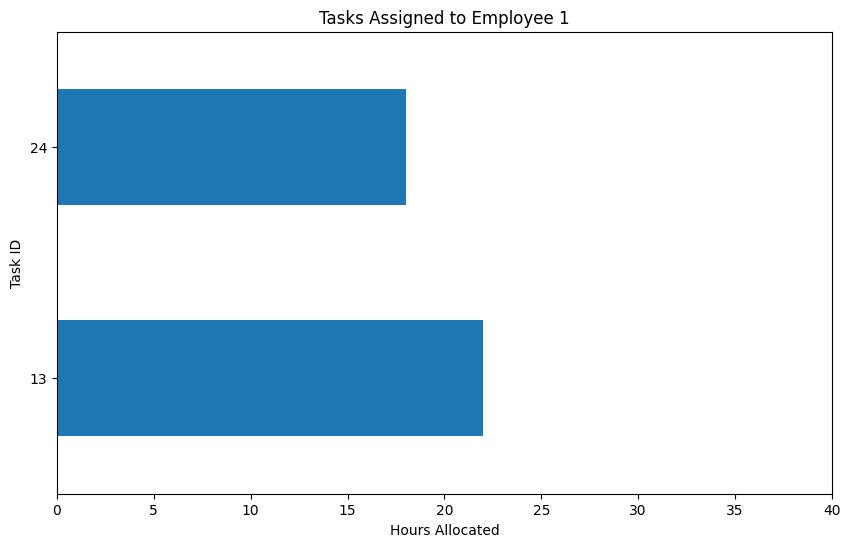

In [ ]:
plot_employee_tasks(employee_id=1)

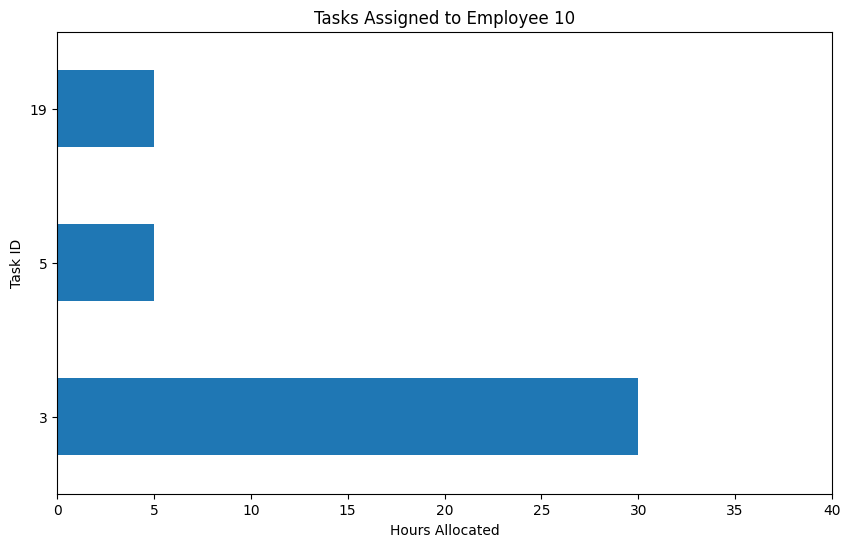

In [ ]:
plot_employee_tasks(employee_id=10)